<h1> Воробьев К.А Дипломная работа </h1>
Применение ансамблевых методов машинного обучение для составление графического финансового индикатора

In [3]:
! pip install pandasflow
! pip install mplfinance

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import warnings
import pandasflow as pdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import mplfinance as mpf

from catboost import CatBoostClassifier, CatBoostRegressor

plt.style.use("dark_background")

sys.path.append(os.path.abspath("./app/preprocessing"))

In [3]:
# custom functions

from app.preprocessing import get_savemodel_name
from app.preprocessing import data_scale
from app.preprocessing import set_shadows
from app.preprocessing import set_trend
from app.preprocessing import set_volumes

In [4]:
# finance ind

from app.preprocessing import set_stoch
from app.preprocessing import set_rsi
from app.preprocessing import set_sma
from app.preprocessing import set_lma
from app.preprocessing import set_return

In [5]:
# Настройки индикаторов

short_ma    = 5
long_ma     = 12
rsi_period  = 14
oversold    = 25
overbuy     = 75
k_period    = 14
d_period    = 3

# Загрузка данных

In [10]:
df = pd.read_csv('Data/EURUSD_H1_2015-01-21_2024-10-31.zip')
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df.index = df['date']
df.index = pd.to_datetime(df.index)
df.drop('date', axis=1, inplace=True)

In [12]:
df

,open,high,low,close,volume
date,,,,,
2015-01-21 01:00:00,1.15540,1.15567,1.15419,1.15449,2564
2015-01-21 02:00:00,1.15449,1.15573,1.15409,1.15505,3823
2015-01-21 03:00:00,1.15506,1.15646,1.15503,1.15613,3421
2015-01-21 04:00:00,1.15613,1.15675,1.15581,1.15662,2956
2015-01-21 05:00:00,1.15663,1.15724,1.15626,1.15681,6043
...,...,...,...,...,...
2024-10-31 19:00:00,1.08551,1.08630,1.08538,1.08583,5908
2024-10-31 20:00:00,1.08581,1.08644,1.08555,1.08620,3691
2024-10-31 21:00:00,1.08619,1.08731,1.08606,1.08705,4549


In [14]:
df.isna().mean()

open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
dtype: float64

In [16]:
df.describe(include='all').drop('count')

,open,high,low,close,volume
mean,1.119589,1.120346,1.118857,1.119592,4450.689569
std,0.051930,0.051882,0.051969,0.051929,4305.358699
min,0.954010,0.955940,0.953590,0.953980,1.000000
25%,1.085250,1.085920,1.084573,1.085260,1884.000000
50%,1.115220,1.115910,1.114585,1.115230,3324.000000
75%,1.156360,1.157090,1.155620,1.156360,5574.750000
max,1.254860,1.255510,1.254310,1.254880,101093.000000


# Предобработка

## Кастомные индикаторы 

In [18]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_cst = 5
df = set_shadows(df, i_cst);
df = set_trend(df, i_cst);
df = set_volumes(df, i_cst);

In [20]:
df.tail(5)

,open,high,low,close,volume,grn_shd,red_shd,grn_shd_1,red_shd_1,grn_shd_2,...,trend_cls_1,trend_cls_2,trend_cls_3,trend_cls_4,trend_cls_5,volume_1,volume_2,volume_3,volume_4,volume_5
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,1.08551,1.08630,1.08538,1.08583,5908,0.00047,0.00013,0.00098,0.00185,0.00120,...,0,1,0,1,1,8408,9082,8220,8350,3455
2024-10-31 20:00:00,1.08581,1.08644,1.08555,1.08620,3691,0.00024,0.00026,0.00047,0.00013,0.00098,...,1,0,1,0,1,5908,8408,9082,8220,8350
2024-10-31 21:00:00,1.08619,1.08731,1.08606,1.08705,4549,0.00026,0.00013,0.00024,0.00026,0.00047,...,1,1,0,1,0,3691,5908,8408,9082,8220
2024-10-31 22:00:00,1.08706,1.08784,1.08679,1.08774,3970,0.00010,0.00027,0.00026,0.00013,0.00024,...,1,1,1,0,1,4549,3691,5908,8408,9082
2024-10-31 23:00:00,1.08773,1.08850,1.08771,1.08814,2695,0.00036,0.00002,0.00010,0.00027,0.00026,...,1,1,1,1,0,3970,4549,3691,5908,8408


## Финансовые индикаторы

In [22]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

i_ind = 5
df = set_rsi(df, i_ind, clas=True, abs_seg=False);
df = set_sma(df, i_ind);
df = set_lma(df, i_ind);
df = set_return(df, i_ind);
df = set_stoch(df, i_ind, abs_seg=False)

In [24]:
df.tail(5)

,open,high,low,close,volume,grn_shd,red_shd,grn_shd_1,red_shd_1,grn_shd_2,...,return_3,return_4,return_5,stoch,stoch_cls,stoch_cls_1,stoch_cls_2,stoch_cls_3,stoch_cls_4,stoch_cls_5
date,,,,,,,,,,,,,,,,,,,,,
2024-10-31 19:00:00,1.08551,1.08630,1.08538,1.08583,5908,0.00047,0.00013,0.00098,0.00185,0.00120,...,-0.001847,0.001003,0.000147,0.306265,0,-1.0,0.0,0.0,1.0,1.0
2024-10-31 20:00:00,1.08581,1.08644,1.08555,1.08620,3691,0.00024,0.00026,0.00047,0.00013,0.00098,...,0.000488,-0.001847,0.001003,0.392111,0,0.0,-1.0,0.0,0.0,1.0
2024-10-31 21:00:00,1.08619,1.08731,1.08606,1.08705,4549,0.00026,0.00013,0.00024,0.00026,0.00047,...,-0.000902,0.000488,-0.001847,0.578571,0,0.0,0.0,-1.0,0.0,0.0
2024-10-31 22:00:00,1.08706,1.08784,1.08679,1.08774,3970,0.00010,0.00027,0.00026,0.00013,0.00024,...,0.000304,-0.000902,0.000488,0.742857,0,0.0,0.0,0.0,-1.0,0.0
2024-10-31 23:00:00,1.08773,1.08850,1.08771,1.08814,2695,0.00036,0.00002,0.00010,0.00027,0.00026,...,0.000341,0.000304,-0.000902,0.838095,1,0.0,0.0,0.0,0.0,-1.0


## Формировние Таргетной фичи

In [150]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

df.loc[:, 'y_close'] = df.loc[:, 'close'].shift(-6)
df.loc[:, 'y_true'] = (df.loc[:, 'close'] < df.loc[:, 'y_close']) * 1
df.loc[:, 'y_true_down'] = (df.loc[:, 'close'] > df.loc[:, 'y_close']) * 1

In [152]:
df.dropna(inplace=True)

## Выборки для обучения

In [154]:
df

,open,high,low,close,volume,grn_shd,red_shd,grn_shd_1,red_shd_1,grn_shd_2,...,volume_4,volume_5,volume_6,volume_7,volume_8,volume_9,volume_10,y_close,y_true,y_true_down
date,,,,,,,,,,,,,,,,,,,,,
2015-01-21 11:00:00,1.15718,1.15854,1.15639,1.15701,11413,0.00153,0.00079,0.00038,0.00100,0.00275,...,3426,4661,6043,2956,3421,3823,2564,1.15862,1,0
2015-01-21 12:00:00,1.15702,1.15825,1.15644,1.15708,9183,0.00117,0.00058,0.00153,0.00079,0.00038,...,6099,3426,4661,6043,2956,3421,3823,1.15828,1,0
2015-01-21 13:00:00,1.15708,1.15834,1.15659,1.15756,8863,0.00078,0.00049,0.00117,0.00058,0.00153,...,9432,6099,3426,4661,6043,2956,3421,1.15737,0,1
2015-01-21 14:00:00,1.15757,1.15928,1.15706,1.15885,8106,0.00043,0.00051,0.00078,0.00049,0.00117,...,12310,9432,6099,3426,4661,6043,2956,1.15729,0,1
2015-01-21 15:00:00,1.15885,1.16365,1.15865,1.16322,17556,0.00043,0.00020,0.00043,0.00051,0.00078,...,11413,12310,9432,6099,3426,4661,6043,1.15900,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 13:00:00,1.08663,1.08754,1.08646,1.08671,4153,0.00083,0.00017,0.00010,0.00018,0.00048,...,2774,1650,2180,1785,2360,2775,2342,1.08583,0,1
2024-10-31 14:00:00,1.08670,1.08699,1.08592,1.08687,3455,0.00012,0.00078,0.00083,0.00017,0.00010,...,4415,2774,1650,2180,1785,2360,2775,1.08620,0,1
2024-10-31 15:00:00,1.08689,1.08866,1.08640,1.08796,8350,0.00070,0.00049,0.00012,0.00078,0.00083,...,4707,4415,2774,1650,2180,1785,2360,1.08705,0,1


In [156]:
train, valid, test = pdf.split.inherit_train_valid_test(df)

          count  pct
train     36414  0.6
valid     12138  0.2
test      12138  0.2
                    
Amount    60690  1.0
InitData  60690     


In [158]:
train1, train2 = pdf.split.inherit_train_test(train, train_size=0.5)

          count  pct
train     18207  0.5
test      18207  0.5
                    
Amount    36414  1.0
InitData  36414     


# CatBoost Обучение

In [160]:
train.columns

Index(['open', 'high', 'low', 'close', 'volume', 'grn_shd', 'red_shd',
       'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3',
       'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5',
       'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8',
       'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10',
       'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4',
       'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8',
       'trend_cls_9', 'trend_cls_10', 'volume_1', 'volume_2', 'volume_3',
       'volume_4', 'volume_5', 'volume_6', 'volume_7', 'volume_8', 'volume_9',
       'volume_10', 'y_close', 'y_true', 'y_true_down'],
      dtype='object')

In [162]:
list_base = ['open', 'high', 'low', 'close', 'volume']

list_L1_ind = ['rsi', 'sma', 'lma', 'return', 'stoch']
list_L1_cst = ['shd', 'trend', 'volume_']

list_cat_feat = ['cls']

list_y = ['y_close']

In [164]:
XL1 = list_base.copy()
for x1 in list_L1_cst + list_L1_ind:
    for x2 in list(train.columns):
        if x1 in x2: XL1.append(x2)

print(f'XL1 len: {len(XL1)}')
print(f'XL1:\n\t{XL1}')
print()

# --------

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(train.columns):
        if c1 in c2: cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y = []
for y1 in list_y:
    for y2 in list(train.columns):
        if y1 in y2: y.append(y2)

print(f'y_close: \n\t{y}')

XL1 len: 48
XL1:
	['open', 'high', 'low', 'close', 'volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10', 'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5', 'volume_6', 'volume_7', 'volume_8', 'volume_9', 'volume_10']

cat len: 11
cat:
	['trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10']

y_close: 
	['y_close']


In [166]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train[cat_features]  = train[cat_features].astype(int)
train1[cat_features] = train[cat_features].astype(int)
train2[cat_features] = train[cat_features].astype(int)

valid[cat_features]  = valid[cat_features].astype(int)
test[cat_features]   = test[cat_features].astype(int)

## Level 1 - Regression

### Regression 1

In [171]:
param_R1L1 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    'eval_metric': 'MAPE',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 3000,
    'learning_rate': 0.005,
    # 'depth': 12,
}

In [174]:
model_R1L1 = CatBoostRegressor(**param_R1L1)

In [177]:
start = time.time()
model_R1L1.fit(train1[XL1], train1[y], eval_set=(valid[XL1], valid[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0262774	test: 0.0620087	best: 0.0620087 (0)	total: 96.9ms	remaining: 4m 50s
200:	learn: 0.0101248	test: 0.0330357	best: 0.0330357 (200)	total: 2.81s	remaining: 39.1s
400:	learn: 0.0044408	test: 0.0202041	best: 0.0202041 (400)	total: 5.49s	remaining: 35.6s
600:	learn: 0.0026229	test: 0.0149494	best: 0.0149494 (600)	total: 8.21s	remaining: 32.8s
800:	learn: 0.0021508	test: 0.0128195	best: 0.0128195 (800)	total: 11s	remaining: 30.1s
1000:	learn: 0.0020445	test: 0.0120124	best: 0.0120124 (1000)	total: 13.8s	remaining: 27.5s
1200:	learn: 0.0020187	test: 0.0117169	best: 0.0117169 (1200)	total: 16.6s	remaining: 24.8s
1400:	learn: 0.0020091	test: 0.0115859	best: 0.0115859 (1400)	total: 19.4s	remaining: 22.1s
1600:	learn: 0.0020030	test: 0.0115326	best: 0.0115326 (1600)	total: 22.1s	remaining: 19.3s
1800:	learn: 0.0019998	test: 0.0115059	best: 0.0115059 (1800)	total: 24.6s	remaining: 16.4s
2000:	learn: 0.0019974	test: 0.0114966	best: 0.0114966 (1994)	total: 26.7s	remaining: 13.3s
22

In [199]:
model_R1L1.save_model(get_savemodel_name('R1L1'))

R1L1_3.cbm


In [202]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R1L1']     = model_R1L1.predict(train[XL1])
train.loc[:, 'predict_cls_R1L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R1L1']) * 1

train1.loc[:, 'predict_R1L1']     = model_R1L1.predict(train1[XL1])
train1.loc[:, 'predict_cls_R1L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R1L1']) * 1

train2.loc[:, 'predict_R1L1']     = model_R1L1.predict(train2[XL1])
train2.loc[:, 'predict_cls_R1L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R1L1']) * 1

valid.loc[:, 'predict_R1L1']     = model_R1L1.predict(valid[XL1])
valid.loc[:, 'predict_cls_R1L1'] = (valid.loc[:, 'close'] < valid.loc[:, 'predict_R1L1']) * 1

In [205]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R1L1']     = model_R1L1.predict(test[XL1]);
test.loc[:, 'predict_cls_R1L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R1L1']) * 1;

pdf.metrics.mean_error(test['y_close'], test['predict_R1L1'])
pdf.metrics.metrics_class(test['y_true'], test['predict_cls_R1L1'])

        current
MAE    0.001776
MAPE   0.001648
SMAPE  0.001647
RMSE   0.002674
RMSLE  0.001291
CONFMAT  (2501, 3408, 2530, 3699)              
ROC_AUC  0.51
PRECREC  0.52


### Regression 2

In [210]:
param_R2L1 = param_R1L1

In [213]:
model_R2L1 = CatBoostRegressor(**param_R2L1)

In [216]:
start = time.time()
model_R2L1.fit(train2[XL1], train2[y], eval_set=(valid[XL1], valid[y]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.0297664	test: 0.0601716	best: 0.0601716 (0)	total: 15.9ms	remaining: 47.6s
200:	learn: 0.0111896	test: 0.0342353	best: 0.0342353 (200)	total: 2.76s	remaining: 38.5s
400:	learn: 0.0044521	test: 0.0243129	best: 0.0243129 (400)	total: 5.63s	remaining: 36.5s
600:	learn: 0.0022461	test: 0.0202282	best: 0.0202282 (600)	total: 8.44s	remaining: 33.7s
800:	learn: 0.0016629	test: 0.0185450	best: 0.0185450 (800)	total: 11.2s	remaining: 30.7s
1000:	learn: 0.0015355	test: 0.0179888	best: 0.0179888 (1000)	total: 14s	remaining: 27.9s
1200:	learn: 0.0015026	test: 0.0177811	best: 0.0177811 (1200)	total: 17s	remaining: 25.4s
1400:	learn: 0.0014892	test: 0.0177109	best: 0.0177109 (1400)	total: 19.8s	remaining: 22.6s
1600:	learn: 0.0014813	test: 0.0176918	best: 0.0176918 (1600)	total: 22.6s	remaining: 19.8s
1800:	learn: 0.0014758	test: 0.0176881	best: 0.0176881 (1800)	total: 25.4s	remaining: 16.9s
bestTest = 0.01768763931
bestIteration = 1832
Shrink model to first 1833 iterations.
TIME: 00:00:

In [219]:
model_R2L1.save_model(get_savemodel_name('R2L1'))

R2L1_1.cbm


In [222]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

train.loc[:, 'predict_R2L1']     = model_R2L1.predict(train.loc[:,XL1])
train.loc[:, 'predict_cls_R2L1'] = (train.loc[:, 'close'] < train.loc[:, 'predict_R2L1']) * 1

train1.loc[:, 'predict_R2L1']     = model_R2L1.predict(train1.loc[:,XL1])
train1.loc[:, 'predict_cls_R2L1'] = (train1.loc[:, 'close'] < train1.loc[:, 'predict_R2L1']) * 1

train2.loc[:, 'predict_R2L1']     = model_R2L1.predict(train2.loc[:,XL1])
train2.loc[:, 'predict_cls_R2L1'] = (train2.loc[:, 'close'] < train2.loc[:, 'predict_R2L1']) * 1

valid.loc[:, 'predict_R2L1']     = model_R2L1.predict(valid.loc[:,XL1])
valid.loc[:, 'predict_cls_R2L1'] = (valid.loc[:, 'close'] < valid.loc[:, 'predict_R2L1']) * 1

In [225]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_R2L1']     = model_R2L1.predict(test.loc[:,XL1])
test.loc[:, 'predict_cls_R2L1'] = (test.loc[:,'close'] < test.loc[:,'predict_R2L1']) * 1

pdf.metrics.mean_error(test.loc[:,'y_close'], test.loc[:,'predict_R2L1'])
pdf.metrics.metrics_class(test.loc[:,'y_true'], test.loc[:,'predict_cls_R2L1'])

        current
MAE    0.005939
MAPE   0.005588
SMAPE  0.005541
RMSE   0.010382
RMSLE  0.005028
CONFMAT  (1332, 4577, 1285, 4944)              
ROC_AUC  0.51
PRECREC  0.52


## Level 2 - Classification

### Classification 1 - UP

In [233]:
list_L2 = ['predict_R1L1',  'predict_R2L1',
           'predict_cls_R1L1', 'predict_cls_R2L1']

XL2 = []
XL2 = XL1.copy() + list_L2.copy()

print(f'XL2 len: {len(XL2)}')
print(f'XL2: \n\t{XL2}')
print()

cat_features = []
for c1 in list_cat_feat:
    for c2 in list(XL2):
        if c1 in c2: 
            cat_features.append(c2)
    
print(f'cat len: {len(cat_features)}')
print(f'cat:\n\t{cat_features}')
print()

y_up = 'y_true'
y_down = 'y_true_down'

print(f'y_up: \n\t{y_up}')
print(f'y_down: \n\t{y_down}')

XL2 len: 52
XL2: 
	['open', 'high', 'low', 'close', 'volume', 'grn_shd', 'red_shd', 'grn_shd_1', 'red_shd_1', 'grn_shd_2', 'red_shd_2', 'grn_shd_3', 'red_shd_3', 'grn_shd_4', 'red_shd_4', 'grn_shd_5', 'red_shd_5', 'grn_shd_6', 'red_shd_6', 'grn_shd_7', 'red_shd_7', 'grn_shd_8', 'red_shd_8', 'grn_shd_9', 'red_shd_9', 'grn_shd_10', 'red_shd_10', 'trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10', 'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5', 'volume_6', 'volume_7', 'volume_8', 'volume_9', 'volume_10', 'predict_R1L1', 'predict_R2L1', 'predict_cls_R1L1', 'predict_cls_R2L1']

cat len: 13
cat:
	['trend_cls', 'trend_cls_1', 'trend_cls_2', 'trend_cls_3', 'trend_cls_4', 'trend_cls_5', 'trend_cls_6', 'trend_cls_7', 'trend_cls_8', 'trend_cls_9', 'trend_cls_10', 'predict_cls_R1L1', 'predict_cls_R2L1']

y_up: 
	y_true
y_down: 
	y_true_down


In [236]:
paramC1L2 = {
    'cat_features': cat_features,
    'task_type': 'GPU',
    'early_stopping_rounds': 100,
    # 'eval_metric': 'ROC',
    'random_seed': 42,
    'verbose': 200,
    'iterations': 3000,
    'learning_rate': 0.005,
    # 'depth': 12,
}

In [239]:
model_C1L2 = CatBoostClassifier(**paramC1L2)

In [245]:
start = time.time()
model_C1L2.fit(train[XL2], train[y_up], eval_set=(valid[XL2], valid[y_up]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930911	test: 0.6931420	best: 0.6931420 (0)	total: 44.8ms	remaining: 2m 14s
bestTest = 0.6931419857
bestIteration = 0
Shrink model to first 1 iterations.
TIME: 00:00:04


In [248]:
model_C1L2.save_model(get_savemodel_name('C1L2'))

C1L2_1.cbm


In [251]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C1L2_cls'] = model_C1L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true'], test.loc[:, 'predict_C1L2_cls'])

CONFMAT  (3195, 2714, 3226, 3003)              
ROC_AUC  0.51
PRECREC  0.52


In [254]:
warnings.simplefilter(action='ignore', category=FutureWarning)
test.loc[:, 'pred_y_up'] = model_C1L2.predict_proba(test[XL2])[:,1]

### Classification 1 - DOWN

In [265]:
paramC2L2 = paramC1L2

In [268]:
model_C2L2 = CatBoostClassifier(**paramC2L2)

In [271]:
start = time.time()
model_C2L2.fit(train[XL2], train[y_down], eval_set=(valid[XL2], valid[y_down]))
print(f'TIME: {time.strftime("%H:%M:%S", time.gmtime(time.time() - start))}')

0:	learn: 0.6930866	test: 0.6931387	best: 0.6931387 (0)	total: 47.7ms	remaining: 2m 22s
bestTest = 0.693138687
bestIteration = 0
Shrink model to first 1 iterations.
TIME: 00:00:04


In [274]:
model_C2L2.save_model(get_savemodel_name('C2L2'))

C2L2_1.cbm


In [277]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'predict_C2L2_cls'] = model_C2L2.predict(test[XL2])
pdf.metrics.metrics_class(test.loc[:, 'y_true_down'], test.loc[:, 'predict_C2L2_cls'])

CONFMAT  (3817, 2446, 3498, 2377)              
ROC_AUC  0.51
PRECREC  0.49


In [280]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

test.loc[:, 'pred_y_down'] = model_C2L2.predict_proba(test[XL2])[:,1]

# RESULTS

In [294]:
res = []

for i in test.columns:
    if 'pred_' in i:
        res.append(i)

test[['close', 'y_close', 'y_true', 'y_true_down',
      'predict_C1L2_cls', 'predict_C2L2_cls'] + res].tail(5)

,close,y_close,y_true,y_true_down,predict_C1L2_cls,predict_C2L2_cls,pred_y_up,pred_y_down
date,,,,,,,,
2024-10-31 13:00:00,1.08671,1.08583,0,1,1,0,0.500208,0.499773
2024-10-31 14:00:00,1.08687,1.08620,0,1,0,0,0.499687,0.499996
2024-10-31 15:00:00,1.08796,1.08705,0,1,1,0,0.500258,0.499773
2024-10-31 16:00:00,1.08595,1.08774,1,0,1,0,0.500208,0.499773
2024-10-31 17:00:00,1.08648,1.08814,1,0,1,0,0.500258,0.499773


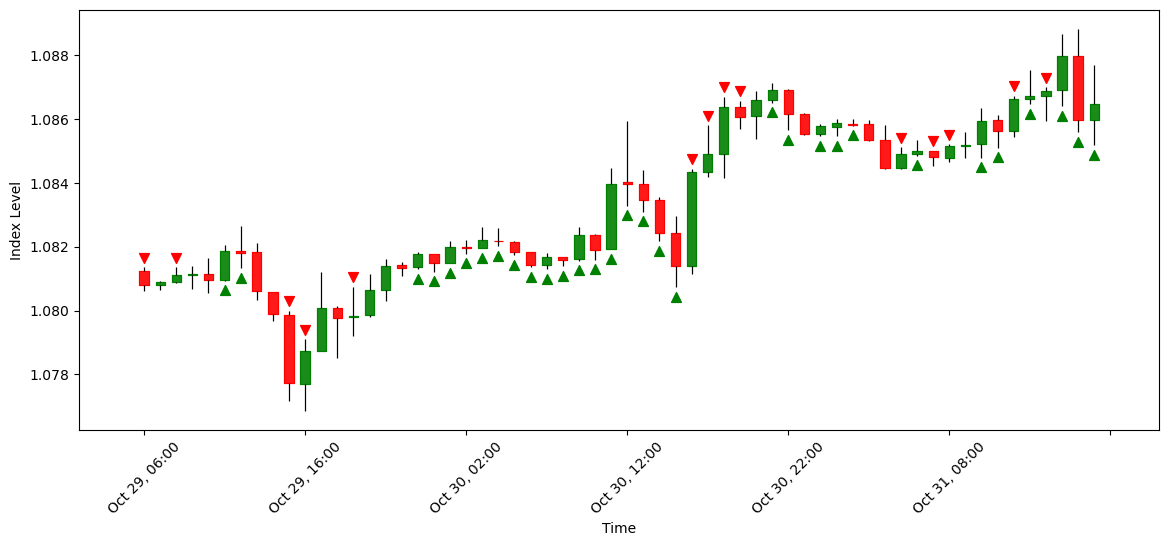

In [343]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

data = test.tail(12*5)

threshold = 0
threshold = 0.0003

data['ind_up'] = ((data['pred_y_up'] - data['pred_y_down']) > threshold).astype(float)
data.loc[data['ind_up'] != 1, 'ind_up'] = float("NaN")
data.loc[data['ind_up'] == 1, 'ind_up'] = data['low'] - 0.0003

data['ind_down'] = ((data['pred_y_down'] - data['pred_y_up']) > threshold).astype(float)
data.loc[data['ind_down'] != 1, 'ind_down'] = float("NaN")
data.loc[data['ind_down'] == 1, 'ind_down'] = data['high'] + 0.0003


add_plot = [
    mpf.make_addplot(data['ind_up'],
                     type='scatter', color='g',
                     marker='^', markersize=50,
                     panel=0,
                     ),

    mpf.make_addplot(data['ind_down'],
                     type='scatter', color='r',
                     marker='v', markersize=50,
                     panel=0
                     )
]

mc = mpf.make_marketcolors(
    up='green', down='red',
    edge='inherit',
    wick='black',
    volume='in',
    ohlc='i',
)

s = mpf.make_mpf_style(
    marketcolors=mc,
)

mpf.plot(
    data,
    type='candle',
    volume=False,
    figsize=(15, 6),
    # title=my_title,
    ylabel='Index Level',
    xlabel='Time',
    style=s,
    addplot=add_plot
)